# Convert geotiff elevation data to printable stl

This notebook depends on you getting your geotiff files from the "national map". 

In [11]:
#imports
from PIL import Image
import sys
import numpy as np
import matplotlib.pyplot as plt
from easygui import fileopenbox
from stl import mesh
import stl
from mpl_toolkits import mplot3d
import cv2

In [2]:
# select all geotiff files
%matplotlib notebook
Image.MAX_IMAGE_PIXELS = None

files = fileopenbox(multiple=True)

for f in files:
    print(f)

arrs = []
for f in files:
    arrs.append(np.array(Image.open(f)))

/home/ship/Downloads/USGS_13_n39w105_20211005.tif
/home/ship/Downloads/USGS_13_n39w106_20211208.tif


In [3]:
# concatinate appropriately. currently this is manual
a = np.concatenate((arrs[1], arrs[0]), axis=1)
print('max height in meters: {}'.format(np.amax(a)))
print('min height in meters: {}'.format(np.amin(a)))
print(a.shape)

max height in meters: 4303.00048828125
min height in meters: 1310.1126708984375
(10812, 21624)


<IPython.core.display.Javascript object>


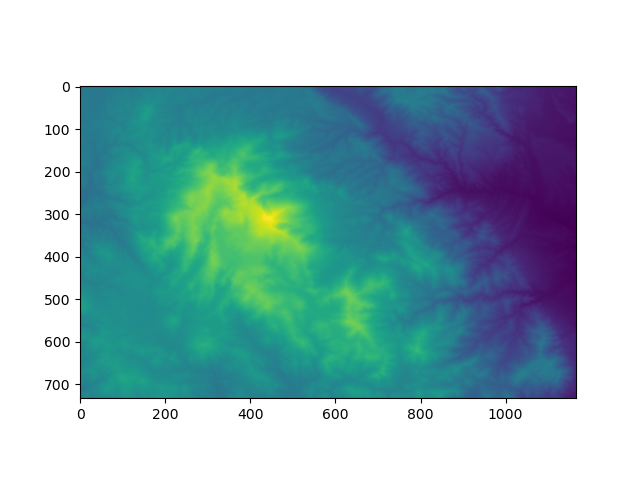

In [142]:
# trim geotiff by selecting new x and y bounds
%matplotlib notebook
xmin = 0
xmax = a.shape[1]
ymin = 0
ymax = a.shape[0]

xmin = 9000
xmax = 12500
ymin= 800
ymax = 3000

s = a[ymin:ymax, xmin:xmax]
plt.imshow(s)
plt.show()

In [143]:
# resize image in opencv
shrink_scale = 3
s = cv2.resize(s, dsize=(int(s.shape[1]/shrink_scale), int(s.shape[0]/shrink_scale)), interpolation=cv2.INTER_CUBIC)
s = s - 1000
s = s / shrink_scale / 10 # divide by 10 for the approximtely 10 meters per px for a 1/3 arcsecond resolution
plt.imshow(s)
plt.show()

In [144]:

y_points, x_points = s.shape

nvectors = ((s.shape[0] - 1) * 2) * (s.shape[1] - 1)
nvectors += 4*x_points + 4*y_points + 2
m = mesh.Mesh(np.zeros(nvectors,dtype=mesh.Mesh.dtype))

print('number of triangles:', nvectors)
i = 0
for iy, ix in np.ndindex((y_points - 1, x_points - 1)):
    m.vectors[i][0] = (ix, - iy,s[iy,ix])
    m.vectors[i][1] = (ix + 1, -iy, s[iy,ix + 1])
    m.vectors[i][2] = (ix, -(iy + 1), s[iy + 1, ix])
    i = i + 1
    m.vectors[i][0] = (ix + 1, -iy,s[iy,ix + 1])
    m.vectors[i][1] = (ix + 1, -(iy+1),s[iy + 1,ix + 1])
    m.vectors[i][2] = (ix, -(iy + 1),s[iy + 1,ix])
    i = i + 1
    
# add the "skirts" of the surface
y_points -= 1
for j in range(x_points - 1):
    m.vectors[i][0] = (j,0,s[0,j])
    m.vectors[i][1] = (j,0,0)
    m.vectors[i][2] = (j+1,0,s[0,j+1])
    i += 1
    m.vectors[i][0] = (j+1,0,s[0,j+1])
    m.vectors[i][1] = (j,0,0)
    m.vectors[i][2] = (j+1,0,0)
    i+= 1
    m.vectors[i][0] = (j,-y_points,s[y_points,j])
    m.vectors[i][1] = (j,-y_points,0)
    m.vectors[i][2] = (j+1,-y_points,s[y_points,j+1])
    i+= 1
    m.vectors[i][0] = (j+1,-y_points,s[y_points,j+1])
    m.vectors[i][1] = (j,-y_points,0)
    m.vectors[i][2] = (j+1,-y_points,0)
    i+= 1

x_points -= 1
for j in range(y_points - 1):
    m.vectors[i][0] = (0, -j, s[j,0])
    m.vectors[i][1] = (0, -(j+1), s[j+1,0])
    m.vectors[i][2] = (0, -j, 0)
    i+=1
    m.vectors[i][0] = (0, -j, 0)
    m.vectors[i][1] = (0, -(j+1), s[j+1,0])
    m.vectors[i][2] = (0, -(j+1), 0)
    i+=1
    m.vectors[i][0] = (x_points, -j, s[j,x_points])
    m.vectors[i][1] = (x_points, -(j+1), s[j+1,x_points])
    m.vectors[i][2] = (x_points, -j, 0)
    i+=1
    m.vectors[i][0] = (x_points, -j, 0)
    m.vectors[i][1] = (x_points, -(j+1), s[j+1,x_points])
    m.vectors[i][2] = (x_points, -(j+1), 0)
    i+=1

# add the bottom of the surface
m.vectors[i][0] = (0,0,0)
m.vectors[i][1] = (x_points, -y_points, 0)
m.vectors[i][2] = (x_points, 0, 0)
i += 1
m.vectors[i][0] = (0,0,0)
m.vectors[i][1] = (x_points, -y_points, 0)
m.vectors[i][2] = (0, -y_points,0)

x_points += 1 
y_points += 1
m.save('model.stl', mode=stl.Mode.BINARY)

number of triangles: 1713158


<IPython.core.display.Javascript object>


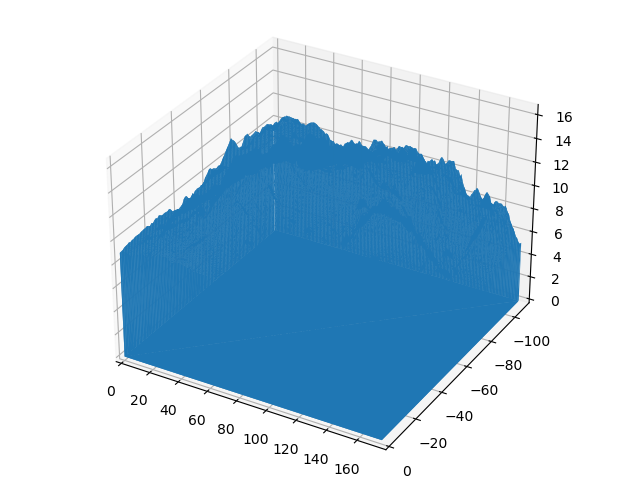

[0.       0.       8.949919 ... 0.       0.       0.      ]


/tmp/ipykernel_33157/3500568077.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(figure)


In [129]:

figure = plt.figure()
axes = mplot3d.Axes3D(figure)

axes.autoscale_view()
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(m.vectors))
axes.set_xlim3d(0,x_points)
axes.set_ylim3d(0,-y_points)
axes.set_zlim3d(0,np.amax(s))
scale = m.points.flatten()
print(scale)
#axes.auto_scale_xyz(10,10,4000)

plt.show()